# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from time import time

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Read in data and basic evaluation

In [3]:
# read the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


### Data Preprocessing (Azdias)

#### Step 1: Drop not described features

With the help of the descriptive files an additional comma-separated values file was created manually. It sorts the features alphabetically, and maps both a type (categorical, mixed, numeric, ordinal) and values corresponding to missing information to each feature. 

The main problem during the file creation was the discrepancy between the features in the datasets and the descriptive files. For example features had slightly different names. But more important not all features could be found in the descriptive files. On the basis of further evaluation missing descriptions could be complemented.

In [8]:
# read in feature info file
feat_info = pd.read_csv('./features.csv', sep=';', names=['Feature', 'Type', 'Unknown'])
feat_list = feat_info['Feature'].tolist()

In [9]:
feat_info.head(15)

,Feature,Type,Unknown
0,AGER_TYP,categorical,"[-1,0]"
1,ALTERSKATEGORIE_FEIN,ordinal,"[-1,0.9]"
2,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
3,ALTER_HH,ordinal,[0]
4,ANREDE_KZ,categorical,"[-1,0]"
5,ANZ_HAUSHALTE_AKTIV,numeric,[]
6,ANZ_HH_TITEL,numeric,[]
7,ANZ_KINDER,numeric,[]
8,ANZ_PERSONEN,numeric,[]
9,ANZ_STATISTISCHE_HAUSHALTE,numeric,[]


In [10]:
# should be an empty array
diff_not_in_feat = list(set(feat_list) - set(azdias))
print('Features in feat_list that are not in azdias:')
print(len(diff_not_in_feat))
print(diff_not_in_feat)
print('***')

# features that are not in feat_info (no information regarding type)
diff_not_in_azdias = list(set(azdias) - set(feat_list))
print('Features in azdias that are not in feat_list:')
print(len(diff_not_in_azdias))
print(diff_not_in_azdias)
print('***')

# should be ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']
diff_customers_azdias = list(set(customers) - set(azdias))
print('Features in customers that are not in azdias:')
print(len(diff_customers_azdias))
print(diff_customers_azdias)
print('***')

Features in feat_list that are not in azdias:
0
[]
***
Features in azdias that are not in feat_list:
32
['LNR', 'RT_SCHNAEPPCHEN', 'VK_DISTANZ', 'EINGEFUEGT_AM', 'CJT_TYP_6', 'AKT_DAT_KL', 'VERDICHTUNGSRAUM', 'ALTER_KIND4', 'VK_ZG11', 'UMFELD_ALT', 'CJT_TYP_1', 'VHN', 'RT_KEIN_ANREIZ', 'CJT_TYP_5', 'D19_LETZTER_KAUF_BRANCHE', 'FIRMENDICHTE', 'CJT_KATALOGNUTZER', 'EXTSEL992', 'GEMEINDETYP', 'CJT_TYP_3', 'UMFELD_JUNG', 'CJT_TYP_2', 'ALTER_KIND1', 'VK_DHT4A', 'ALTER_KIND2', 'CJT_TYP_4', 'KOMBIALTER', 'VHA', 'RT_UEBERGROESSE', 'ALTER_KIND3', 'D19_KONSUMTYP_MAX', 'STRUKTURTYP']
***
Features in customers that are not in azdias:
3
['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']
***


In [11]:
# drop features
azdias.drop(labels=diff_not_in_azdias, axis=1, inplace=True)

In [12]:
azdias.shape

(891221, 334)

#### Step 2: Convert missing or unknown values to NaN

The manually created feature info file contains all values corresponding to missing information. Additionally to the already existing NaN values in the datasets these placeholders have to be converted to NaN values.

In [15]:
unknown = pd.Series(feat_info['Unknown'].values, index=feat_info['Feature'])
unknown

Feature
AGER_TYP                           [-1,0]
ALTERSKATEGORIE_FEIN             [-1,0.9]
ALTERSKATEGORIE_GROB             [-1,0,9]
ALTER_HH                              [0]
ANREDE_KZ                          [-1,0]
ANZ_HAUSHALTE_AKTIV                    []
ANZ_HH_TITEL                           []
ANZ_KINDER                             []
ANZ_PERSONEN                           []
ANZ_STATISTISCHE_HAUSHALTE             []
ANZ_TITEL                              []
ARBEIT                                [9]
BALLRAUM                             [-1]
CAMEO_DEUG_2015                ['-1','X']
CAMEO_DEU_2015                     ['XX']
CAMEO_INTL_2015               ['-1','XX']
CJT_GESAMTTYP                         [0]
D19_BANKEN_ANZ_12                     [0]
D19_BANKEN_ANZ_24                     [0]
D19_BANKEN_DATUM                     [10]
D19_BANKEN_DIREKT                     [0]
D19_BANKEN_GROSS                      [0]
D19_BANKEN_LOKAL                      [0]
D19_BANKEN_OFFLINE_DATUM  

In [16]:
for col in azdias:
    isin = ast.literal_eval(unknown[col])
    azdias[col] = azdias[col].mask(azdias[col].isin(isin), other=np.nan)

azdias.head()

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,SOHO_KZ,TITEL_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2.0
1,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,NaN,1.0,2.0,3.0,9.0,4.0,5,2,1.0
2,NaN,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,NaN,0.0,1.0,3.0,9.0,2.0,5,2,3.0
3,2.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,NaN,0.0,1.0,NaN,9.0,7.0,3,2,4.0
4,NaN,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,NaN,0.0,2.0,2.0,9.0,3.0,4,1,3.0


#### Step 3: Drop columns because of too many NaNs

In [17]:
# calculate the percentage of missing values per feature
missing_per_column = azdias.isnull().mean()

(array([  32.,    0.,    0.,   10.,  146.,   13.,   58.,    2.,    0.,
           0.,    0.,    2.,    0.,    1.,    0.,    1.,    0.,    1.,
           0.,    1.,    1.,    1.,    3.,    0.,    0.,    2.,    3.,
           1.,    3.,    4.,    3.,    1.,    5.,    4.,    6.,    3.,
           7.,    5.,    8.,    7.]),
 array([ 0.        ,  0.0249779 ,  0.04995579,  0.07493369,  0.09991158,
         0.12488948,  0.14986737,  0.17484527,  0.19982316,  0.22480106,
         0.24977895,  0.27475685,  0.29973475,  0.32471264,  0.34969054,
         0.37466843,  0.39964633,  0.42462422,  0.44960212,  0.47458001,
         0.49955791,  0.52453581,  0.5495137 ,  0.5744916 ,  0.59946949,
         0.62444739,  0.64942528,  0.67440318,  0.69938107,  0.72435897,
         0.74933686,  0.77431476,  0.79929266,  0.82427055,  0.84924845,
         0.87422634,  0.89920424,  0.92418213,  0.94916003,  0.97413792,
         0.99911582]),
 <a list of 40 Patch objects>)

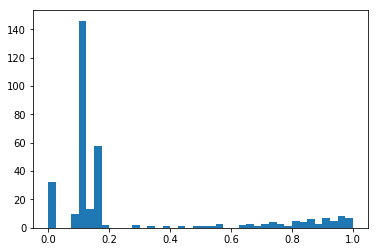

In [27]:
plt.hist(missing_per_column, bins=40)

In [20]:
# features to be dropped have more than 20% missing values 
drop_missing_per_column = missing_per_column[missing_per_column > 0.2].index

# drop features
azdias.drop(labels=drop_missing_per_column, axis=1, inplace=True)

In [21]:
# what features have been dropped
drop_missing_per_column

Index(['AGER_TYP', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24'

In [22]:
azdias.shape

(891221, 261)

#### Step 4: Drop rows because of too many NaNs

In [23]:
# calculate the percentage of missing values per individual
missing_per_row = azdias.isnull().sum(axis=1)

(array([  6.54805000e+05,   3.21760000e+04,   3.39930000e+04,
          1.46810000e+04,   9.99000000e+02,   5.42000000e+02,
          8.40000000e+01,   7.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.60000000e+01,   8.77900000e+03,   3.24900000e+03,
          9.50100000e+03,   1.60590000e+04,   8.59000000e+02,
          3.69800000e+03,   4.85900000e+03,   6.04000000e+02,
          2.05000000e+02,   2.11000000e+02,   4.80000000e+01,
          3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.06000000e+02,   9.50000000e+01,   3.80000000e+01,
        

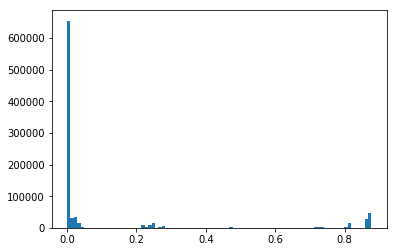

In [28]:
plt.hist(missing_per_row / azdias.shape[1], bins=90)

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row (our threshold is 30% of missing values)
def split_dataset(df, missing_per_row, threshold=0.3):
    """
    Splits data into two subsets based on the missing values per row.

    INPUT:
    - df (DataFrame): DataFrame to be split
    - missing_per_row: calculated percentage of missing values per row
    - threshold (float): threshold as decision criteria for splitting

    OUTPUT:
    - DataFrame: DataFrame with a smaller percentage of missing values than the threshold 
    - DataFrame: DataFrame with a higher percentage of missing values than the threshold
    """
    
    above_th = df[missing_per_row / df.shape[1] <= threshold]
    below_th = df[missing_per_row / df.shape[1] > threshold]
    return above_th, below_th
    
azdias, azdias_row_nan = split_dataset(azdias, missing_per_row)

In [30]:
azdias.shape[0]/891221

0.8809902369894784

In [31]:
azdias_row_nan.shape

(106064, 261)

#### Step 5a: Select and Re-Encode Categorical Features

In [32]:
# how many categorical features do we have?
categorical = feat_info[feat_info['Type'] == 'categorical']
categorical.shape

(26, 3)

In [33]:
def access_features(feature_type):
    """
    Access features of a specific type.

    INPUT:
    - feature_type (str): feature type (categorical, mixed, numeric, ordinal)

    OUTPUT: None
    """
    
    for i in range (0, feat_info.shape[0]):
        t = feat_info.at[i,'Type']
        f = feat_info.at[i,'Feature']
        try:
            if(t == feature_type):
                print(f, azdias.loc[: , f].unique())
        except KeyError:
            print(f + ' was eliminated already')

In [34]:
# Assess categorical features
access_features('categorical')

AGER_TYP was eliminated already
ANREDE_KZ [2 1]
CAMEO_DEUG_2015 [8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 nan '4' '3' '7' '2' '8' '9' '6' '5'
 '1']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '7A' '5D' '9E' '9B'
 '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']
CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan]
D19_KONSUMTYP was eliminated already
DSL_FLAG [ 1.  0.]
FINANZTYP [1 6 5 2 4 3]
GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
GREEN_AVANTGARDE [0 1]
HH_DELTA_FLAG [  0.  nan   1.]
KK_KUNDENTYP was eliminated already
KONSUMZELLE [  1.   0.  nan]
LP_FAMILIE_FEIN [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3. 

In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.
# 26 features, 4 dropped in steps before, 20 numerical - no changes (simplification)

# dummies for binary non-numerical
col_ow = azdias.loc[: , 'OST_WEST_KZ']
s_ow = pd.Series(col_ow)
azdias = pd.concat([azdias.drop('OST_WEST_KZ', axis=1), pd.get_dummies(s_ow, dummy_na=True, drop_first=True)], axis=1)

# drop fine features, rough features are still available
azdias.drop(['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'], axis=1, inplace=True)

# CAMEO_DEUG_2015 as float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('float64')

In [36]:
azdias.shape

(785157, 259)

#### Step 5b: Select and Re-Encode Mixed Features

In [37]:
# how many mixed features do we have?
mixed = feat_info[feat_info['Type'] == 'mixed']
mixed.shape

(4, 3)

In [38]:
# Assess mixed features
access_features('mixed')

CAMEO_INTL_2015 [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0 nan
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']
LP_LEBENSPHASE_FEIN [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  20.   1.  25.  13.
  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.  12.  39.
  27.  36.   9.  34.  33.  15.  11.  40.  16.  19.  17.]
LP_LEBENSPHASE_GROB [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
PRAEGENDE_JUGENDJAHRE [ 14.  15.   8.   3.  10.  11.   9.   6.   4.  nan   5.   2.   1.  12.  13.
   7.]


In [39]:
def convert_pj_to_dec(val):
    """
    Converts value of feature PRAEGENDE_JUGENDJAHRE to a DECADE value.

    INPUT:
    - val (int): original value

    OUTPUT:
    - int: converted value (0: 40s, 1: 50s, 2: 60s, 3: 70s, 4: 80s, 5: 90s)
    """
    
    result = val
    if (val > 0 and val <= 2):
        result = 0 #40s
    elif (val <= 4):
        result = 1 #50s
    elif (val <= 7):
        result = 2 #60s
    elif (val <= 9):
        result = 3 #70s
    elif (val <= 13):
        result = 4 #80s
    elif (val <= 15):
        result = 5 #90
    return result

def convert_pj_to_move(val):
    """
    Converts value of feature PRAEGENDE_JUGENDJAHRE to a MOVEMENT value.

    INPUT:
    - val (int): original value

    OUTPUT:
    - int: converted value (0: Mainstream, 1: Avantgarde)
    """
    
    result = val
    if (val in [1,3,5,8,10,12,14]):
        result = 0 # M
    elif (val in [2,4,6,7,9,11,13,15]):
        result = 1 # A
    return result

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_dec(x))
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_move(x))

# drop PRAEGENDE_JUGENDJAHRE
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

# drop CAMEO_INTL_2015
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [42]:
# drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB because no clear structure available
azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

In [43]:
azdias.shape

(785157, 259)

#### Step 6: Feature Scaling

Missing values are imputed with the median of the corresponding feature. Because of the majority of categorical and ordinal features it is superior to imputing mean values. Afterwards the features were standardised.

In [44]:
imputer = Imputer(strategy='median')
scaler = StandardScaler()

In [45]:
# impute median and scale azdias
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias))
azdias_scaled = scaler.fit_transform(azdias_imputed)

### Put it all together - Cleaning function

In [46]:
def clean_data(df, feat_info, drop_not_described, drop_nan_col, split=False):
    """
    Cleans a DataFrame including the following steps:
    - Drop not described features
    - Convert missing values
    - Drop features with high percentage of missing values
    - Drop rows with high percentage of unknown values (optional)
    - Re-encode features

    INPUT:
    - df (DataFrame): the DataFrame to be cleaned
    - feat_info (DataFrame): the DataFrame containing the feature information
    - drop_not_described (list): list of features to be dropped because they are not contained in the feature info
    - drop_nan_col (list): list of features to be dropped because of a high percentage of missing values
    - split (bool): if True rows with a high percentage of missing values are extracted

    OUTPUT:
    - DataFrame: cleaned DataFrame
    - DataFrame (only if split=True): DataFrame containing rows with many missing values
    """
    
    # drop features that are not described
    df.drop(labels=drop_not_described, axis=1, inplace=True)
    
    # convert missing or unknown
    unknown = pd.Series(feat_info['Unknown'].values, index=feat_info['Feature'])
    for col in df:
        isin = ast.literal_eval(unknown[col])
        df[col] = df[col].mask(df[col].isin(isin), other=np.nan)
    
    # drop columns because of too many NaN
    df.drop(labels=drop_nan_col, axis=1, inplace=True)
    
    # split if necessary
    df_row_nan = pd.DataFrame()
    if(split):
        missing_per_row = df.isnull().sum(axis=1)
        df, df_row_nan = split_dataset(df, missing_per_row)
    
    # Re-encode categorical features
    # dummies for binary non-numerical
    col_ow = df.loc[: , 'OST_WEST_KZ']
    s_ow = pd.Series(col_ow)
    df = pd.concat([df.drop('OST_WEST_KZ', axis=1), pd.get_dummies(s_ow, dummy_na=True, drop_first=True)], axis=1)

    # drop fine features
    df.drop(['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'], axis=1, inplace=True)

    # CAMEO_DEUG_2015 as float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float64')
    
    # Re-encode mixed features
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_dec(x))
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_move(x))

    # drop PRAEGENDE_JUGENDJAHRE
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

    # drop CAMEO_INTL_2015
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB because no clear structure available
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    if(split):
        return df, df_row_nan
    else:
        return df

### Customer Data Preprocessing

In [47]:
# for customers three additional columns have to be dropped before cleaning
customers.drop(diff_customers_azdias, axis=1, inplace=True)

In [48]:
# clean data
customers, customers_row_nan = clean_data(customers, feat_info, diff_not_in_azdias, drop_missing_per_column, split=True)
customers.shape

(140343, 259)

In [49]:
customers.shape[0]/191652

0.7322803831945401

In [50]:
# impute median and scale customers, use already existing imputer and scaler objects
customers_imputed = pd.DataFrame(imputer.transform(customers))
customers_scaled = scaler.transform(customers_imputed)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA

For clustering a PCA is not necessarily a precondition, but it reduces noise and therefore clustering methods are better able to distinguish the different clusters.

In [51]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    """
    Creates a scree plot associated with the principal components. 
    
    INPUT:
    - pca (PCA): the result of instantiation of PCA in scikit learn
            
    OUTPUT: None
    """
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(40, 24))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


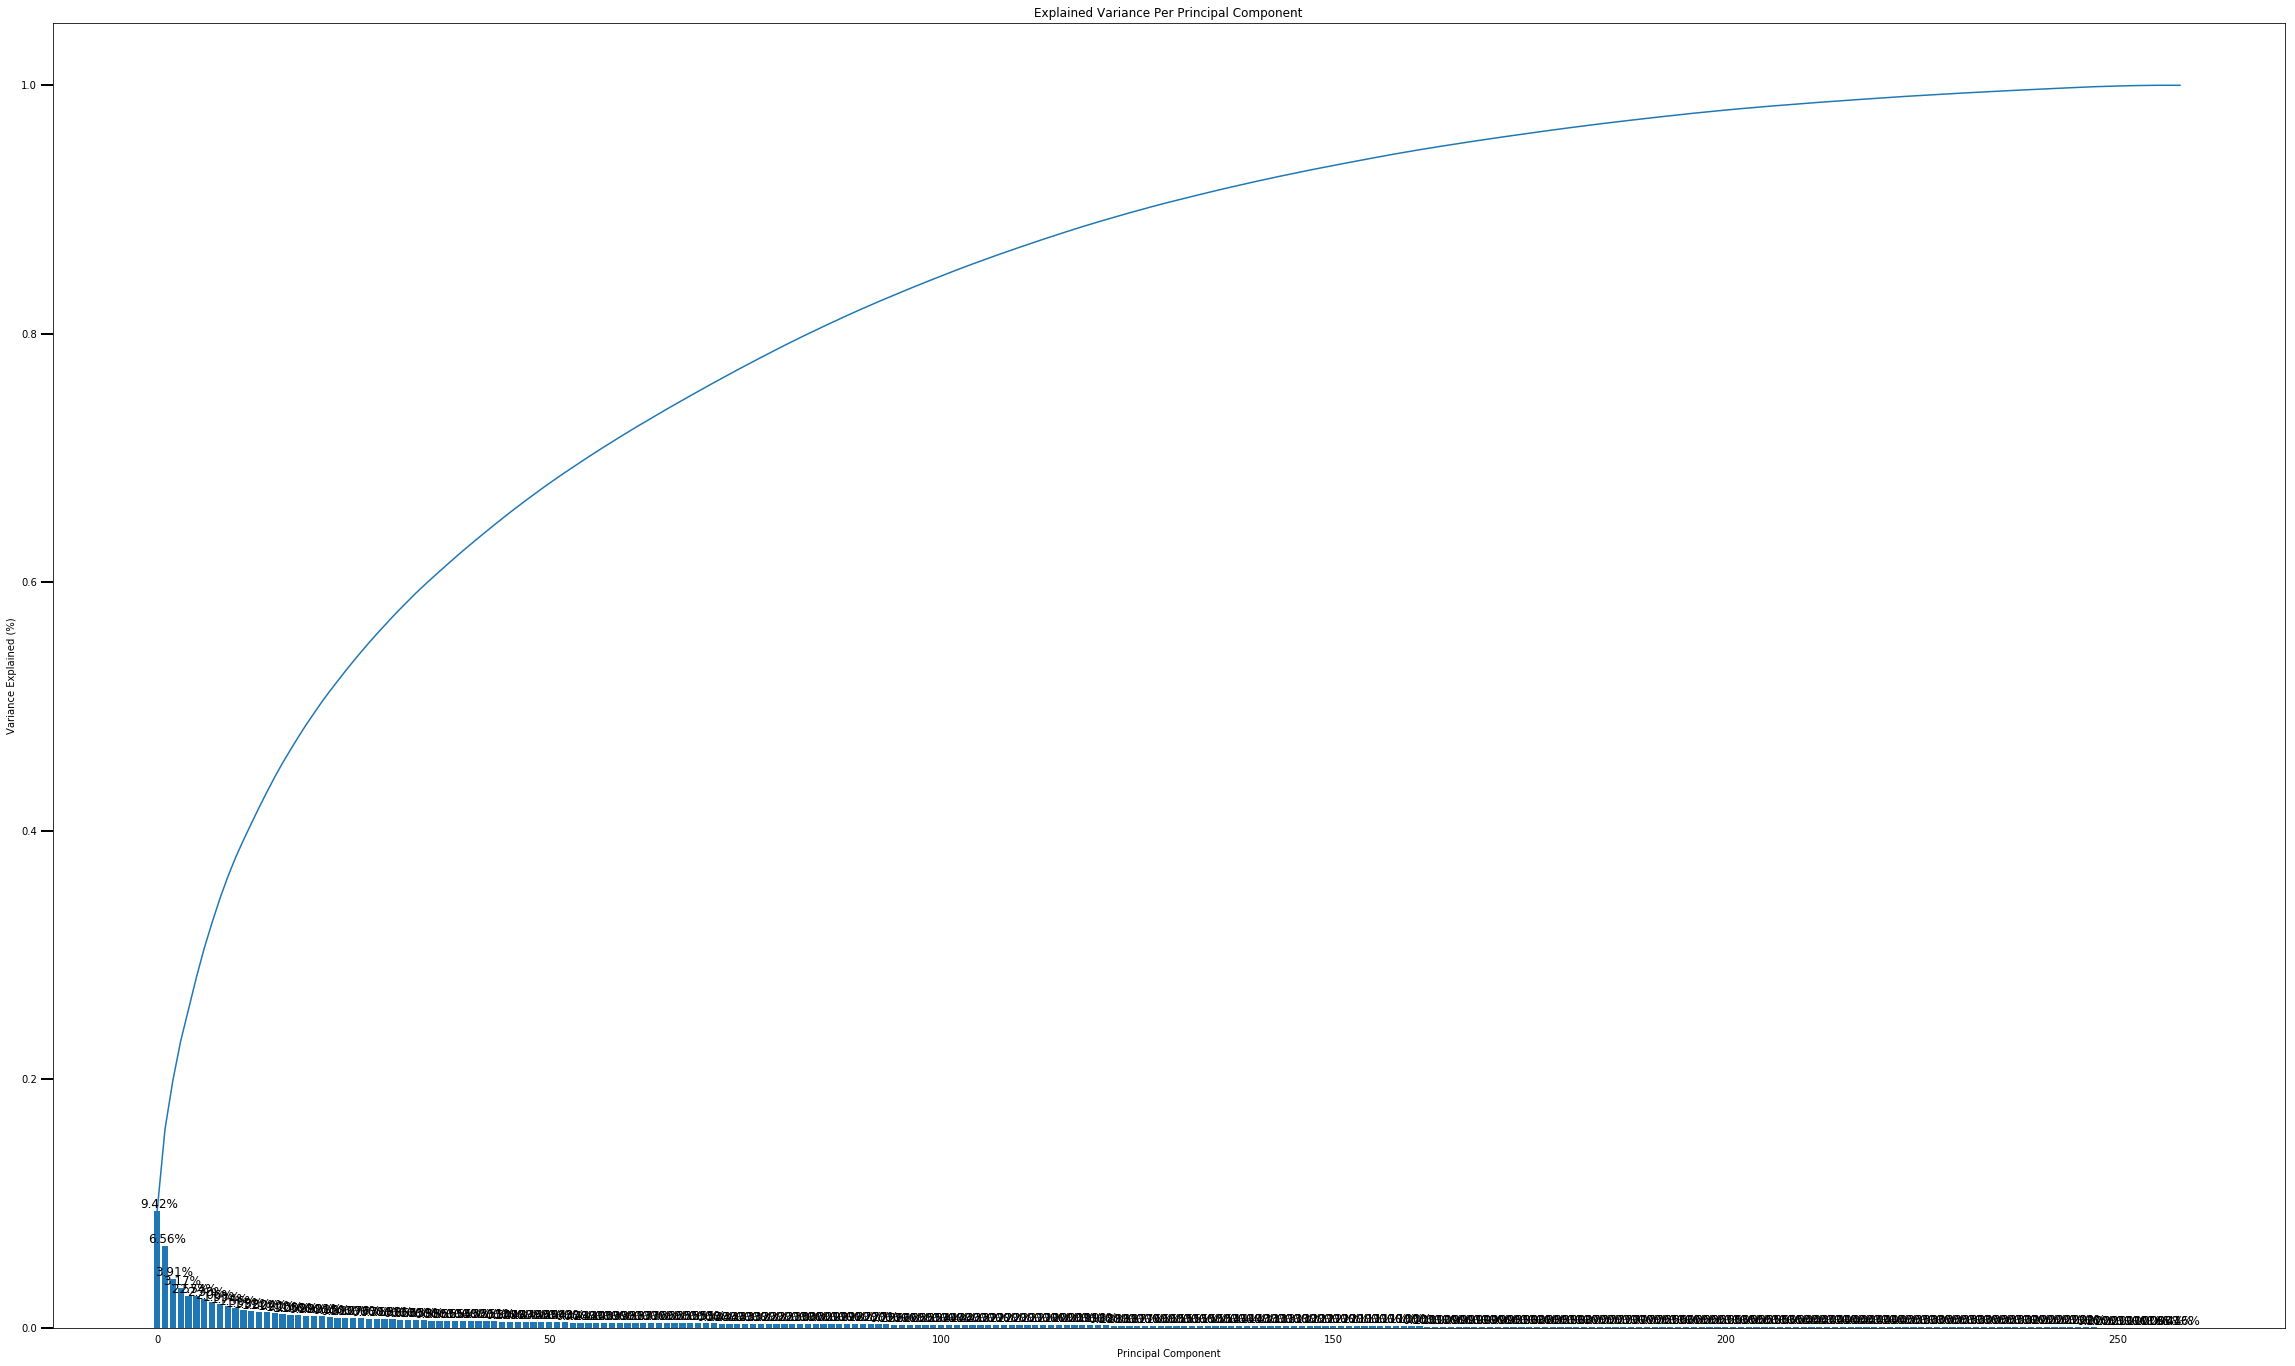

In [52]:
# Apply PCA to the data
pca_full = PCA()
X_azdias_pca_full = pca_full.fit_transform(azdias_scaled)
scree_plot(pca_full)

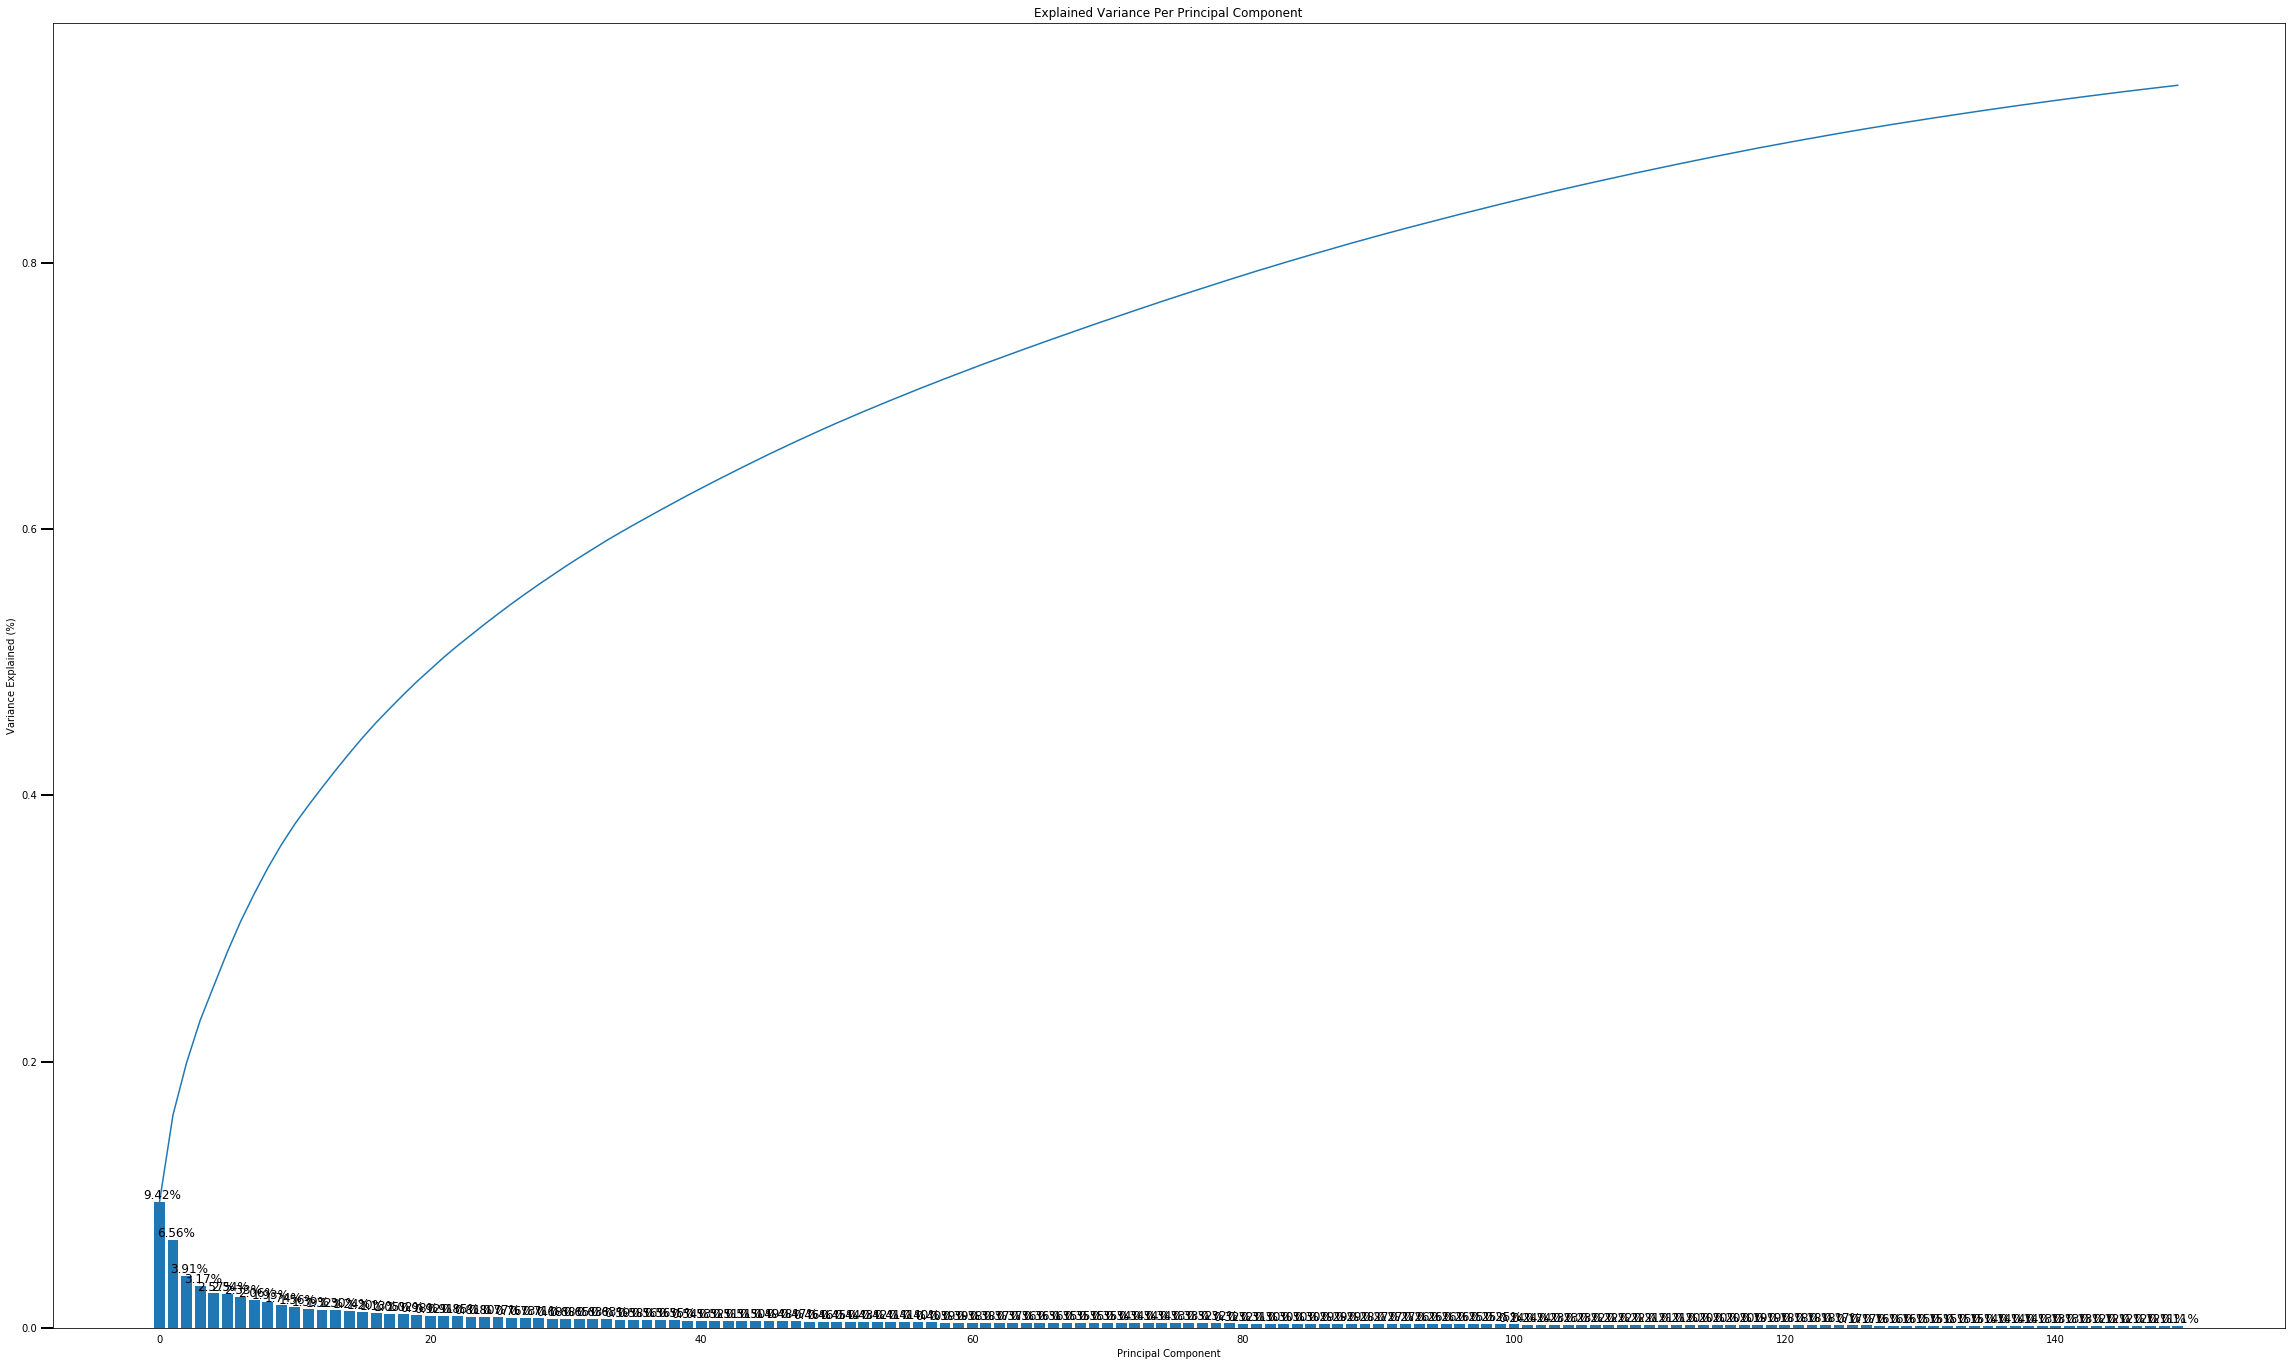

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain
pca = PCA(n_components=150, random_state=12)
X_azdias_pca = pca.fit_transform(azdias_scaled)
scree_plot(pca)

In [54]:
# apply PCA to the customers dataset
X_customers_pca = pca.transform(customers_scaled)

### Clustering and Evaluation

In [55]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
cluster_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
distances = []

def apply_kmeans(data, clusters):
    """
    Computed the average within-cluster distances. 
    
    INPUT:
    - data (array): the result from PCAs fit_transform function
    - clusters (int): number of clusters for k-means
            
    OUTPUT: None
    """
    
    kmeans = KMeans(n_clusters=clusters, random_state=12)
    preds = kmeans.fit_predict(data)
    pred_centroids = kmeans.cluster_centers_
    centers = pred_centroids[preds]
    distance = np.sqrt(((data - centers) ** 2).sum(axis = 1)).mean()
    distances.append(distance)
    print(distance)

In [13]:
for i in cluster_nums:
    apply_kmeans(X_azdias_pca,i)

15.3827638605
14.7983958373
14.5654338139
14.3972089843
14.2719435284
14.171895588
14.0830660012
14.0147016886
13.9543377884
13.9098734736
13.8650712024
13.8254177048
13.7908336631
13.7613853386
13.7415892484
13.7144961261
13.6879261863
13.664218527
13.6423072428
13.614928628


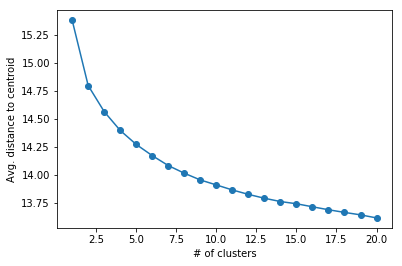

In [14]:
# Investigate the change in within-cluster distance across number of clusters (elbow method).
plt.plot(cluster_nums, distances, '-o')
plt.ylabel('Avg. distance to centroid')
plt.xlabel('# of clusters')
plt.show()

In [56]:
# run KMeans with the "optimal" number of clusters (from elbow method)
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=12)

# for the general population
azdias_preds = kmeans.fit_predict(X_azdias_pca)

In [57]:
# build a map for the general population, containing index and cluster predictions
cluster_map_azdias = pd.DataFrame()
cluster_map_azdias['data_index'] = azdias.index.values
cluster_map_azdias['cluster'] = azdias_preds

In [58]:
# for the customers
customers_preds = kmeans.predict(X_customers_pca)

In [59]:
# build a map for the customers, containing index and cluster predictions
cluster_map_customers = pd.DataFrame()
cluster_map_customers['data_index'] = customers.index.values
cluster_map_customers['cluster'] = customers_preds

### Comparison

In [60]:
azd_helper = azdias_row_nan.shape[0]
cst_helper = customers_row_nan.shape[0]

In [61]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

azd_unique, azd_counts = np.unique(azdias_preds, return_counts=True)
azd = dict(zip(azd_unique, azd_counts / (azdias.shape[0] + azd_helper)))
azd[n_clusters] = azd_helper/(azdias.shape[0] + azd_helper)

cst_unique, cst_counts = np.unique(customers_preds, return_counts=True)
cst = dict(zip(cst_unique, cst_counts / (customers.shape[0] + cst_helper)))
cst[n_clusters] = cst_helper/(customers.shape[0] + cst_helper)

print(azd)
print(cst)

{0: 0.063199812392212479, 1: 0.11858113756296138, 2: 0.092781700610735166, 3: 0.06739518032003286, 4: 0.12735898278878077, 5: 0.12629302945060764, 6: 0.068279360562643832, 7: 0.12702124388900171, 8: 0.090079789412502623, 9: 0.11900976301052152}
{0: 0.091989647903491747, 1: 0.10598376223571891, 2: 0.014782000709619519, 3: 0.015705549642059568, 4: 0.29402249911297562, 5: 0.13640348130987415, 6: 0.021043349404128317, 7: 0.016018617076785008, 8: 0.036331475799887297, 9: 0.2677196168054599}


In [62]:
# add individuals that were separated because of a high percentage of missing values as extra cluster
# as k-means would have predicted cluster #9

azd_with_separated = azdias_preds.copy()
for i in range (0,azd_helper): # add separated as extra group 
    azd_with_separated = np.append(azd_with_separated, n_clusters) 

cst_with_separated = customers_preds.copy()
for i in range (0,cst_helper): # add separated as extra group
    cst_with_separated = np.append(cst_with_separated, n_clusters) 

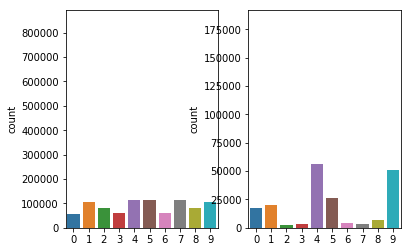

In [63]:
# print cluster proportions 

ax1 = plt.subplot(121)
ax1.set_ylim(0, azdias.shape[0] + azd_helper)
sns.countplot(azd_with_separated)
ax2 = plt.subplot(122)
ax2.set_ylim(0, customers.shape[0] + cst_helper)
sns.countplot(cst_with_separated)

### Feature Selection

In [86]:
def binarize_clusters(cluster, cluster_map):
    """
    Converts the cluster predictions to 0 if not the target cluster, otherwise to 1. 
    
    INPUT:
    - cluster (int): number of cluster
    - cluster_map (DataFrame): DataFrame containing index and cluster prediction
            
    OUTPUT:
    - DataFrame: DataFrame with the binarized values
    """
    helper = 99
    x = cluster_map['cluster'].copy()
    x[x == cluster] = helper
    x[x != helper] = 0
    x[x == helper] = 1
    return x

In [82]:
def fit_and_find_important_features(df_scaled, preds, gscv):
    """
    Fits a DataFrame and prediction values to a classifier
    and print the most important features according to the classifiers coefficients.
    
    INPUT:
    - df_scaled (DataFrame): a DataFrame with standarized values
    - preds (DataFrame): DataFrame containing binarized cluster predictions
    - gscv (GridSearchCV): GridSearchCV object containing the classifier for coefficient determination
            
    OUTPUT: None
    """
    
    gscv.fit(df_scaled, preds)
    print(gscv.best_score_)
    
    fi_sorted = np.sort(gscv.best_estimator_.coef_[0])
    
    threshold = fi_sorted[len(fi_sorted)-5]
    fi_indices = np.where(gscv.best_estimator_.coef_[0] >= threshold)

    for i in fi_indices:
        print(customers.columns[i])

In [184]:
def calc_mean_median(cluster_map, df_imputed, target_cluster, features):
    """
    Calculates and prints mean and median for a defined set of features of a DataFrame filtered to a target cluster.
    
    INPUT:
    - cluster_map (DataFrame): DataFrame containing index and cluster prediction
    - df_imputed (DataFrame): a DataFrame with imputed values
    - target_cluster (int): number of cluster to investigate (filter function)
    - features (dict): containing feature names and corresponding indices
            
    OUTPUT: None
    """
    
    indexed_map = cluster_map.set_index('data_index')
    joined = df_imputed.join(indexed_map)
    filtered = joined[joined["cluster"] == target_cluster]
    for f in features:
        print(f, filtered[features[f]].mean(), filtered[features[f]].median())

In [75]:
# use LogisticRegression with GridSearchCV for feature selection
clf = LogisticRegression(random_state=12)
gscv = GridSearchCV(estimator=clf, param_grid={}, scoring='roc_auc', cv=5)

#### Investigate Cluster 4

In [76]:
# find important features
target_cluster = 4
cst_preds_4 = binarize_clusters(target_cluster, cluster_map_customers)
fit_and_find_important_features(customers_scaled, cst_preds_4, gscv)

0.933671529596
Index(['KBA05_KW2', 'KBA13_KW_61_120', 'KBA13_MOTOR', 'ALTERSKATEGORIE_GROB',
       'W'],
      dtype='object')


In [188]:
# calculate mean and median
target_cluster = 4
features = {'KBA05_KW2': 60, 'KBA13_KW_61_120': 172, 'KBA13_MOTOR': 178, 'ALTERSKATEGORIE_GROB': 252, 'W': 253}

# for customers
calc_mean_median(cluster_map_customers, customers_imputed.filter(features.values()), target_cluster, features)

KBA05_KW2 3.07739218818 3.0
KBA13_KW_61_120 3.08704806157 3.0
KBA13_MOTOR 2.77757610958 3.0
ALTERSKATEGORIE_GROB 3.48983592275 4.0
W 0.919485988094 1.0


In [189]:
# for general population
calc_mean_median(cluster_map_azdias, azdias_imputed.filter(features.values()), target_cluster, features)

KBA05_KW2 2.99492133041 3.0
KBA13_KW_61_120 2.99360685122 3.0
KBA13_MOTOR 2.7824039036 3.0
ALTERSKATEGORIE_GROB 2.79605656244 3.0
W 0.788448516232 1.0


#### Investigate Cluster 0

In [87]:
# find important features
target_cluster = 0
cst_preds_0 = binarize_clusters(target_cluster, cluster_map_customers)
fit_and_find_important_features(customers_scaled, cst_preds_0, gscv)

0.993440419195
Index(['EWDICHTE', 'KBA13_ALTERHALTER_61', 'KBA13_ANTG2', 'KBA13_HALTER_66',
       'WEALTH'],
      dtype='object')


In [195]:
# calculate mean and median
target_cluster = 0
features = {'EWDICHTE': 12, 'KBA13_ALTERHALTER_61': 95, 'KBA13_ANTG2': 97, 'KBA13_HALTER_66': 139, 'WEALTH': 257}

# for customers
calc_mean_median(cluster_map_customers, customers_imputed.filter(features.values()), target_cluster, features)

EWDICHTE 3.88662113922 4.0
KBA13_ALTERHALTER_61 3.27394071085 3.0
KBA13_ANTG2 2.74778829738 3.0
KBA13_HALTER_66 3.23653577526 3.0
WEALTH 2.60887785193 2.0


In [196]:
# for general population
calc_mean_median(cluster_map_azdias, azdias_imputed.filter(features.values()), target_cluster, features)

EWDICHTE 3.94600924748 4.0
KBA13_ALTERHALTER_61 3.12498233287 3.0
KBA13_ANTG2 2.78086700184 3.0
KBA13_HALTER_66 3.11113130212 3.0
WEALTH 3.27486017728 4.0


#### Investigate Cluster 7

In [88]:
# find important features
target_cluster = 7
cst_preds_7 = binarize_clusters(target_cluster, cluster_map_customers)
fit_and_find_important_features(customers_scaled, cst_preds_7, gscv)

0.988490101211
Index(['ANZ_STATISTISCHE_HAUSHALTE', 'FINANZ_ANLEGER', 'SEMIO_PFLICHT', 'W',
       'DECADE'],
      dtype='object')


In [197]:
# calculate mean and median
target_cluster = 7
features = {'ANZ_STATISTISCHE_HAUSHALTE': 4, 'FINANZ_ANLEGER': 13, 'SEMIO_PFLICHT': 237, 'W': 253, 'DECADE': 255}

# for customers
calc_mean_median(cluster_map_customers, customers_imputed.filter(features.values()), target_cluster, features)

ANZ_STATISTISCHE_HAUSHALTE 5.02161188654 1.0
FINANZ_ANLEGER 1.59117514633 1.0
SEMIO_PFLICHT 3.01260693381 3.0
W 0.928410625844 1.0
DECADE 1.92841062584 2.0


In [198]:
# for general population
calc_mean_median(cluster_map_azdias, azdias_imputed.filter(features.values()), target_cluster, features)

ANZ_STATISTISCHE_HAUSHALTE 7.58482584826 3.0
FINANZ_ANLEGER 2.83746837468 3.0
SEMIO_PFLICHT 4.18750187502 4.0
W 0.790007900079 1.0
DECADE 3.31002310023 3.0


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Read in and basic evaluation

In [127]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [128]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [129]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [133]:
# Imbalance of REPONSE column
vc = mailout_train['RESPONSE'].value_counts()

In [136]:
# positive response
vc[1]/(vc[0]+vc[1])

0.012383036171500396

In [138]:
# negative response
vc[0]/(vc[0]+vc[1])

0.98761696382849962

### Data Preprocessing

In [139]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

In [140]:
# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [141]:
# copied from output Part 0 - Step 1
features_not_described = ['VHN', 'D19_KONSUMTYP_MAX', 'VHA', 'D19_LETZTER_KAUF_BRANCHE', 'GEMEINDETYP', 'VK_DHT4A', 'ALTER_KIND4', 'LNR', 'RT_UEBERGROESSE', 'EINGEFUEGT_AM', 'STRUKTURTYP', 'FIRMENDICHTE', 'UMFELD_JUNG', 'ALTER_KIND1', 'CJT_TYP_2', 'CJT_TYP_5', 'CJT_TYP_3', 'AKT_DAT_KL', 'UMFELD_ALT', 'CJT_KATALOGNUTZER', 'CJT_TYP_6', 'RT_KEIN_ANREIZ', 'CJT_TYP_4', 'RT_SCHNAEPPCHEN', 'KOMBIALTER', 'ALTER_KIND2', 'VK_ZG11', 'CJT_TYP_1', 'EXTSEL992', 'VK_DISTANZ', 'ALTER_KIND3', 'VERDICHTUNGSRAUM']

In [142]:
# find features to drop because of many missing values
missing_per_column = mailout_train.isnull().mean()

(array([ 113.,    0.,    0.,    0.,    0.,   16.,  229.,    2.,    0.,
           0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    3.]),
 array([ 0.        ,  0.0293837 ,  0.05876739,  0.08815109,  0.11753478,
         0.14691848,  0.17630218,  0.20568587,  0.23506957,  0.26445327,
         0.29383696,  0.32322066,  0.35260435,  0.38198805,  0.41137175,
         0.44075544,  0.47013914,  0.49952283,  0.52890653,  0.55829023,
         0.58767392,  0.61705762,  0.64644131,  0.67582501,  0.70520871,
         0.7345924 ,  0.7639761 ,  0.7933598 ,  0.82274349,  0.85212719,
         0.88151088,  0.91089458,  0.94027828,  0.96966197,  0.99904567]),
 <a list of 34 Patch objects>)

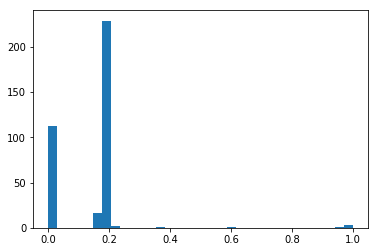

In [143]:
plt.hist(missing_per_column, bins=34)

In [144]:
# define threshold, might be different to the threshold in Part 1
# output shows that other features than in Part 1 should be dropped
drop_missing_per_column = missing_per_column[missing_per_column > 0.25].index
drop_missing_per_column = list(set(drop_missing_per_column) - set(features_not_described))
drop_missing_per_column

['KK_KUNDENTYP']

In [145]:
# clean data, no splitting of rows necessary
mailout_train = clean_data(mailout_train, feat_info, features_not_described, drop_missing_per_column)
mailout_train.shape

(42962, 331)

In [146]:
# impute median and scale azdias
imputer = Imputer(strategy='median')
scaler = StandardScaler()

In [147]:
mailout_train_imputed = pd.DataFrame(imputer.fit_transform(mailout_train))
mailout_train_scaled = scaler.fit_transform(mailout_train_imputed)

### Classification

First step to find a model with an adequate classification performance is testing several classification algorithms in their basic form, i.e. without tuning.

In [148]:
def classify(clf, param_grid, X_train=mailout_train_scaled, y_train=response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [149]:
# LogisticRegression
lor = LogisticRegression(random_state=12)
classify(lor, {})

0.737154191316


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [150]:
# BaggingClassifier
bac = BaggingClassifier(random_state=12)
classify(bac, {})

0.575484853724


BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=12,
         verbose=0, warm_start=False)

In [151]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=12)
classify(rfc, {})

0.550600827625


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [152]:
# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=12)
abc_best_est = classify(abc, {})

0.74375389218


In [153]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=12)
classify(gbc, {})

0.760801959266


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=12, subsample=1.0, verbose=0,
              warm_start=False)

### Model Tuning

In [154]:
# tune the most promising classifier with the help of GridSearchCV
# the result is our model that will be used with the test set
gbc = GradientBoostingClassifier(random_state=12)
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 3],
              'n_estimators':[80],
              'random_state': [12]
             }

gbc_best_est = classify(gbc, param_grid)
gbc_best_est

0.770805086873


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=12, subsample=1.0, verbose=0,
              warm_start=False)

### Feature Selection

In [155]:
# analyse the most important features of the model
fi = pd.DataFrame({'FI':gbc_best_est.feature_importances_}, index=mailout_train.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
D19_SOZIALES,0.185134
ANZ_KINDER,0.074132
D19_BANKEN_LOKAL,0.061682
D19_GARTEN,0.052955
GEBURTSJAHR,0.038139
D19_VERSI_ONLINE_QUOTE_12,0.030483
EINGEZOGENAM_HH_JAHR,0.027396
MIN_GEBAEUDEJAHR,0.025239
NaN,0.021139
D19_TECHNIK,0.019201


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### Read in data and basic evaluation 

In [156]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [157]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [158]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


### Data Preprocessing

In [159]:
# extract lnr for later generation of the competition result file
lnr = mailout_test.LNR

In [160]:
# clean data
mailout_test = clean_data(mailout_test, feat_info, features_not_described, drop_missing_per_column)
mailout_test.shape

(42833, 331)

In [161]:
# impute median and scale azdias 
mailout_test_imputed = pd.DataFrame(imputer.transform(mailout_test))
mailout_test_scaled = scaler.transform(mailout_test_imputed)

### Classification

In [162]:
# use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = gbc_best_est.predict_proba(mailout_test_scaled)
response_test

array([[ 0.96854307,  0.03145693],
       [ 0.96705533,  0.03294467],
       [ 0.99737381,  0.00262619],
       ..., 
       [ 0.97917688,  0.02082312],
       [ 0.97017272,  0.02982728],
       [ 0.97868521,  0.02131479]])

### Output file for Kaggle competition

In [163]:
# generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,0]})
result.to_csv(path_or_buf='./result.csv', index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.968543
1,1770,0.967055
2,1465,0.997374
3,1470,0.998160
4,1478,0.998010
5,1782,0.996842
6,1485,0.997991
7,1519,0.975194
8,1835,0.978374
9,1522,0.997248
